In [1]:
# import duckdb
# import folium
import geopandas as gpd
import json
# import mercantile
import numpy as np
import os
import pandas as pd
import pyarrow.parquet as pq
import requests
import shutil

import sys
from pathlib import Path
from shapely import wkb, wkt
from shapely.geometry import Point, Polygon, box, shape
from shapely.wkb import loads as wkb_loads
from shapely.wkt import loads
from typing import Dict, Any, Union
from tqdm import tqdm
# from lonboard import viz

In [2]:
shapefile_path = "../data/SHP/ConurbacionesSICA_PS.shp"
gdf = gpd.read_file(shapefile_path, crs='EPSG:4326')

In [3]:
geojson_data = gdf.to_json()

# # Step 3: Create a Folium map with satellite background
# m = folium.Map(location=[gdf.geometry.centroid.y.mean(), gdf.geometry.centroid.x.mean()], zoom_start=10)

# # Step 4: Add GeoJSON data to the map
# folium.GeoJson(
#     geojson_data,
#     name='geojson'
# ).add_to(m)

# # Step 5: Add satellite background
# folium.TileLayer(tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}', name='satellite', attr='Esri').add_to(m)

# # Step 6: Add Layer Control
# folium.LayerControl().add_to(m)
# m

In [4]:
df = pd.read_csv('../data/0/worldcities.csv')
df = df[df['country'] == 'Dominican Republic']

df.head()

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
319,Santo Domingo,Santo Domingo,18.4764,-69.8933,Dominican Republic,DO,DOM,Ozama,primary,2581827.0,1214636202
571,Santiago,Santiago,19.4572,-70.6889,Dominican Republic,DO,DOM,Cibao Norte,admin,1343423.0,1214985348
937,Santo Domingo Este,Santo Domingo Este,18.4855,-69.8734,Dominican Republic,DO,DOM,Ozama,admin,948855.0,1214664832
2226,Puerto Plata,Puerto Plata,19.8000,-70.6833,Dominican Republic,DO,DOM,Cibao Norte,minor,318419.0,1214279422
2261,La Victoria,La Victoria,18.5500,-69.9000,Dominican Republic,DO,DOM,Ozama,NaN,312345.0,1214692077


In [5]:
df = pd.read_csv('../data/0/worldcities.csv')
# List of Central American countries
iso2_codes = ['DO','BZ', 'CR', 'SV', 'GT', 'HN', 'NI', 'PA', 'HT', 'JM', 'CU']

# Filter the DataFrame for Central American countries
df = df[df['iso2'].isin(iso2_codes)]
df = df[df['population'] > 100000]
df = df.sort_values(by='population', ascending=False)
cities = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['lng'], df['lat']))

# Function to create bounding box around each point based on population
def create_bbox_based_on_population(row):
    # Define the minimum and maximum bounding box sizes
    min_size = 5
    max_size = 30
    
    # Calculate the size of the bounding box based on population
    population = row['population']
    bbox_size = min_size + (max_size - min_size) * (population / cities['population'].max())
    
    # Convert distance from kilometers to degrees (approximate)
    distance_deg = bbox_size / 111.0
    lon, lat = row['geometry'].x, row['geometry'].y
    return box(lon - distance_deg, lat - distance_deg, lon + distance_deg, lat + distance_deg)

# Create bounding box around each point based on population
cities['bbox'] = cities.apply(create_bbox_based_on_population, axis=1)
city_polygons = cities['bbox'].unary_union # merge

city_polygons_geom = shape(city_polygons)
individual_polygons = list(city_polygons_geom.geoms)
bbox_list = [poly.bounds for poly in individual_polygons]

# Create GeoDataFrame for bounding boxes
bbox_gdf = gpd.GeoDataFrame(geometry=[box(*bbox) for bbox in bbox_list], crs='EPSG:4326')

In [6]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import box, shape

# Load the data
df = pd.read_csv('../data/0/worldcities.csv')

# List of Central American countries
iso2_codes = ['DO','BZ', 'CR', 'SV', 'GT', 'HN', 'NI', 'PA', 'HT', 'JM', 'CU']

# Filter the DataFrame for Central American countries
df = df[df['iso2'].isin(iso2_codes)]
df = df[df['population'] > 100000]
df = df.sort_values(by='population', ascending=False)

# Create GeoDataFrame
cities = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['lng'], df['lat']))

# Function to create bounding box around each point based on population
def create_bbox_based_on_population(row):
    # Define the minimum and maximum bounding box sizes
    min_size = 5
    max_size = 30
    
    # Calculate the size of the bounding box based on population
    population = row['population']
    bbox_size = min_size + (max_size - min_size) * (population / cities['population'].max())
    
    # Convert distance from kilometers to degrees (approximate)
    distance_deg = bbox_size / 111.0
    lon, lat = row['geometry'].x, row['geometry'].y
    return box(lon - distance_deg, lat - distance_deg, lon + distance_deg, lat + distance_deg)

# Create bounding box around each point based on population
cities['bbox'] = cities.apply(create_bbox_based_on_population, axis=1)
city_polygons = cities['bbox'].unary_union # merge

city_polygons_geom = shape(city_polygons)
individual_polygons = list(city_polygons_geom.geoms)
bbox_list = [poly.bounds for poly in individual_polygons]

# Create GeoDataFrame for bounding boxes
bbox_gdf = gpd.GeoDataFrame(geometry=[box(*bbox) for bbox in bbox_list], crs='EPSG:4326')

# Assign correct city_ascii and iso3 to each bounding box polygon
bbox_gdf['city_ascii'] = ""
bbox_gdf['iso3'] = ""

for index, row in cities.iterrows():
    city_name = row['city_ascii']
    iso3 = row['iso3']
    city_geom = row['geometry']
    
    for i, bbox in enumerate(individual_polygons):
        bbox_geom = shape(bbox)
        if bbox_geom.contains(city_geom):
            bbox_gdf.at[i, 'city_ascii'] = city_name
            bbox_gdf.at[i, 'iso3'] = iso3
            break

In [7]:
len(bbox_gdf)

95

In [8]:
output_path = '../data/0/SICA_cities.parquet'
bbox_gdf.to_parquet(output_path)
bbox_gdf.to_file('../data/0/SICA_cities.geojson', driver='GeoJSON')

In [9]:
centroid = cities.geometry.unary_union.centroid
m = folium.Map(location=[centroid.y, centroid.x], zoom_start=5)
for idx, bbox in bbox_gdf.iterrows():
    folium.GeoJson(bbox['geometry']).add_to(m)
m

NameError: name 'folium' is not defined

## Overture Maps

### Querying directly

In [6]:
# Import jupysql Jupyter extension to create SQL cells
con = duckdb.connect("../data/0/data.db")

# con.install_extension('httpfs')
# con.install_extension('spatial')
con.load_extension('httpfs')
con.load_extension('spatial')
con.execute("SET s3_region='us-west-2'")
con.execute("SET azure_storage_connection_string = 'DefaultEndpointsProtocol=https;AccountName=overturemapswestus2;AccountKey=;EndpointSuffix=core.windows.net';")

### OR ###

# %load_ext sql
# %sql duckdb:///:default:

# %sql SET s3_region='us-west-2'
# %sql -- INSTALL spatial
# %sql -- INSTALL httpfs
# %sql LOAD spatial
# %sql LOAD httpfs

# %config SqlMagic.autopandas = True
# %config SqlMagic.feedback = False
# %config SqlMagic.displaycon = False

In [7]:
# ### CENTRAL AMERICA - DOWNLOAD ONCE TO DATA.DB
# xmin = -92.9471760146
# xmax = -68.2053296346
# ymin = 7.2337573643
# ymax = 23.4188526595

# # Creating the SQL query with the bounding box constraints
# query = f"""
# CREATE TABLE buildings AS
# SELECT *
# FROM read_parquet('s3://overturemaps-us-west-2/release/2024-04-16-beta.0/theme=buildings/type=building/*', hive_partitioning=1)
# WHERE bbox.xmin > {xmin}
#   AND bbox.xmax < {xmax}
#   AND bbox.ymin > {ymin}
#   AND bbox.ymax < {ymax};
# """

# con.sql(query)

In [9]:
# coordinates = [[[-70.1560805913,18.372680107],[-69.5854513522,18.372680107],[-69.5854513522,18.6220991307],[-70.1560805913,18.6220991307],[-70.1560805913,18.372680107]]]
# flat_coordinates = [item for sublist in coordinates for item in sublist]

# xmin = min(coordinate[0] for coordinate in flat_coordinates)
# xmax = max(coordinate[0] for coordinate in flat_coordinates)
# ymin = min(coordinate[1] for coordinate in flat_coordinates)
# ymax = max(coordinate[1] for coordinate in flat_coordinates)
gdf = gpd.read_file("../data/1/UNITAC_data/SantoDomingo_PS_modified.geojson")
bounds = gdf.total_bounds
xmin, ymin, xmax, ymax = bounds[0], bounds[1], bounds[2], bounds[3]

query = f"""
    SELECT
        *
        --ST_GeomFromWKB(geometry) as geometry
    FROM buildings
    WHERE bbox.xmin > {xmin}
      AND bbox.xmax < {xmax}
      AND bbox.ymin > {ymin}
      AND bbox.ymax < {ymax};
"""
con.sql(query)

┌──────────────────────┬──────────────────────┬──────────────────────┬───┬─────────────┬───────────┬──────────┐
│          id          │       geometry       │         bbox         │ … │ eave_height │   theme   │   type   │
│       varchar        │         blob         │ struct(xmin float,…  │   │   double    │  varchar  │ varchar  │
├──────────────────────┼──────────────────────┼──────────────────────┼───┼─────────────┼───────────┼──────────┤
│ 08b4cd42dbc42fff02…  │ \x00\x00\x00\x00\x…  │ {'xmin': -69.9984,…  │ … │        NULL │ buildings │ building │
│ 08b4cd42dbc42fff02…  │ \x00\x00\x00\x00\x…  │ {'xmin': -69.99836…  │ … │        NULL │ buildings │ building │
│ 08b4cd42dbc40fff02…  │ \x00\x00\x00\x00\x…  │ {'xmin': -69.99804…  │ … │        NULL │ buildings │ building │
│ 08b4cd42dbc40fff02…  │ \x00\x00\x00\x00\x…  │ {'xmin': -69.99804…  │ … │        NULL │ buildings │ building │
│ 08b4cd42dbc40fff02…  │ \x00\x00\x00\x00\x…  │ {'xmin': -69.99805…  │ … │        NULL │ buildings │ bui

In [10]:
buildings = con.sql(query).to_df()
buildings = gpd.GeoDataFrame(buildings, geometry=gpd.GeoSeries.from_wkb(buildings.geometry.apply(bytes)), crs='EPSG:4326')

buildings['source'] = buildings['sources'].apply(lambda x: [entry['dataset'].strip(',') for entry in x])
buildings['confidence'] = buildings.apply(lambda row: [entry['confidence'] if 'OpenStreetMap' not in row['source'] else 1 for entry in row['sources']], axis=1)
buildings['source'] = buildings['source'].apply(lambda x: str(x).strip('[]'))
buildings['confidence'] = buildings['confidence'].apply(lambda x: str(x).strip('[]'))
buildings['confidence'] = pd.to_numeric(buildings['confidence'], errors='coerce')

print(buildings['confidence'].mean())
print(buildings['source'].value_counts())

buildings = buildings[['id','geometry', 'source', 'confidence']]
buildings.head()


0.808523046069606
source
'Google Open Buildings'     239520
'Microsoft ML Buildings'     54015
'OpenStreetMap'              26751
Name: count, dtype: int64


,id,geometry,source,confidence
0,08b4cd42dbc42fff02002198c1f2e380,"POLYGON ((-69.99827 18.42676, -69.99827 18.426...",'Google Open Buildings',0.67
1,08b4cd42dbc42fff02001512277040cd,"POLYGON ((-69.99827 18.42673, -69.99827 18.426...",'Google Open Buildings',0.72
2,08b4cd42dbc40fff0200c307dbd1caad,"POLYGON ((-69.99792 18.42673, -69.99804 18.426...",'Google Open Buildings',0.68
3,08b4cd42dbc40fff02009c388762207d,"POLYGON ((-69.99792 18.42673, -69.99792 18.426...",'Google Open Buildings',0.74
4,08b4cd42dbc40fff02003a2f4b256269,"POLYGON ((-69.99792 18.42677, -69.99791 18.426...",'Google Open Buildings',0.86


In [11]:
buildings = gpd.GeoDataFrame(buildings).to_crs("EPSG:4326")
buildings.to_file("../data/0/overture/santodomingo_buildings.geojson",driver="GeoJSON")
buildings.to_parquet("../data/0/overture/santodomingo_buildings.parquet")

In [12]:
# Viz with Lonboard
viz(buildings)

Map(basemap_style=<CartoBasemap.DarkMatter: 'https://basemaps.cartocdn.com/gl/dark-matter-gl-style/style.json'…

In [5]:
def query_buildings_within_bbox(coordinates, con, polygon_name):
    # Extracting bounding box coordinates
    flat_coordinates = [item for sublist in coordinates for item in sublist]
    x_coordinates = [coord[0] for coord in flat_coordinates]
    y_coordinates = [coord[1] for coord in flat_coordinates]
    xmin = min(x_coordinates)
    xmax = max(x_coordinates)
    ymin = min(y_coordinates)
    ymax = max(y_coordinates)
    
    # Constructing SQL query
    query = f"""
        SELECT
            *
        FROM buildings
        WHERE bbox.xmin > {xmin}
        AND bbox.xmax < {xmax}
        AND bbox.ymin > {ymin}
        AND bbox.ymax < {ymax};
    """
    
    # Executing SQL query
    buildings = con.sql(query).to_df()

    # Converting geometry to GeoDataFrame
    buildings = gpd.GeoDataFrame(buildings, geometry=gpd.GeoSeries.from_wkb(buildings.geometry.apply(bytes)), crs='EPSG:4326')
    
    # Extracting source and confidence information
    buildings['source'] = buildings['sources'].apply(lambda x: [entry['dataset'].strip(',') for entry in x])
    buildings['confidence'] = buildings.apply(lambda row: [entry['confidence'] if 'OpenStreetMap' not in row['source'] else 1 for entry in row['sources']], axis=1)

    buildings['source'] = buildings['source'].apply(lambda x: str(x).strip('[]'))
    buildings['confidence'] = buildings['confidence'].apply(lambda x: str(x).strip('[]'))
    buildings['confidence'] = pd.to_numeric(buildings['confidence'], errors='coerce')
    
    # Selecting required columns and converting to GeoDataFrame
    buildings = buildings[['id','geometry', 'source', 'confidence']]
    buildings = gpd.GeoDataFrame(buildings).to_crs("EPSG:4326")
    
    # Writing to files
    buildings.to_file(f"../data/0/overture/{polygon_name}.geojson", driver="GeoJSON")
    buildings.to_parquet(f"../data/0/overture/{polygon_name}.parquet")
    print("Done!")

coordinates = [[[-91.5667086154,14.8059076488],[-91.4725068302,14.8059076488],[-91.4725068302,14.8871496368],[-91.5667086154,14.8871496368],[-91.5667086154,14.8059076488]]]
query_buildings_within_bbox(coordinates, con, "quetzaltenango")


Done!


In [39]:
# Define the bounding box coordinates
minx, miny, maxx, maxy = -70.5, 18.2, -69.8, 18.8

# Create a bounding box geometry
bbox = box(minx, miny, maxx, maxy)

# Filter the GeoDataFrame using the bounding box
filtered_gdf = gdf.cx[minx:maxx, miny:maxy]

# Print the filtered GeoDataFrame
filtered_gdf.head()


,avg_d_kbps,avg_u_kbps,avg_lat_ms,devices,geometry
703270,27950.0,16396,23,1,POINT (-70.42511 18.75811)
703271,15418.0,8782,27,1,POINT (-70.43610 18.74251)
703272,10627.0,4452,31,1,POINT (-70.43060 18.74251)
703273,20789.0,439,43,1,POINT (-70.43610 18.73731)
703274,10362.0,6774,24,1,POINT (-70.36469 18.74771)


/opt/miniconda3/envs/rastervision/lib/python3.12/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


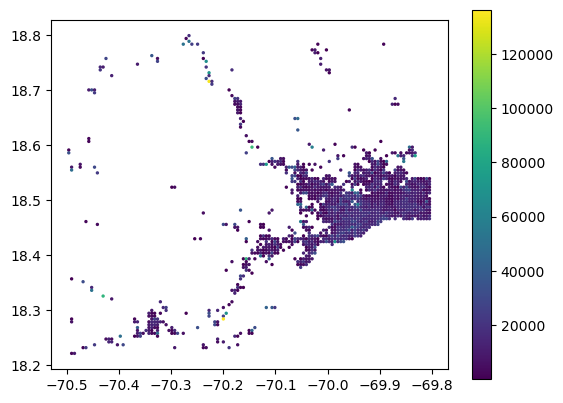

In [43]:
import matplotlib.pyplot as plt
filtered_gdf['avg_d_kbps'] = filtered_gdf['avg_d_kbps'].astype(float)  # Ensure the column is float type for coloring

fig, ax = plt.subplots(1, 1)
filtered_gdf.plot(column='avg_d_kbps', ax=ax, legend=True, markersize=2, cmap='viridis')

plt.show()

In [24]:
# LONBOARD tutorial
from pathlib import Path

import geopandas as gpd
import numpy as np
import pandas as pd
import shapely
from ipywidgets import FloatRangeSlider, jsdlink
from palettable.colorbrewer.diverging import BrBG_10

from lonboard import Map, ScatterplotLayer
from lonboard.colormap import apply_continuous_cmap
from lonboard.controls import MultiRangeSlider
from lonboard.layer_extension import DataFilterExtension

url = "https://ookla-open-data.s3.us-west-2.amazonaws.com/parquet/performance/type=mobile/year=2019/quarter=1/2019-01-01_performance_mobile_tiles.parquet"
local_path = Path("data-filter-extension.parquet")
if local_path.exists():
    gdf = gpd.read_parquet(local_path)
else:
    columns = ["avg_d_kbps", "avg_u_kbps", "avg_lat_ms", "devices", "tile"]
    df = pd.read_parquet(url, columns=columns)

    tile_geometries = shapely.from_wkt(df["tile"])
    tile_centroids = shapely.centroid(tile_geometries)
    non_geom_columns = [col for col in columns if col != "tile"]
    gdf = gpd.GeoDataFrame(df[non_geom_columns], geometry=tile_centroids, crs="EPSG:4326")
    gdf.to_parquet(local_path)

filter_extension = DataFilterExtension(filter_size=3)

min_bound = 5000
max_bound = 50000
normalized_download_speed = (gdf["avg_d_kbps"] - min_bound) / (max_bound - min_bound)
fill_color = apply_continuous_cmap(normalized_download_speed, BrBG_10)
radius = normalized_download_speed * 200

filter_values = np.column_stack(
    [gdf["avg_d_kbps"], gdf["avg_u_kbps"], gdf["avg_lat_ms"]]
)
initial_filter_range = [
    [10_000, 50_000],
    [1000, 10_000],
    [0, 100],
]

layer = ScatterplotLayer.from_geopandas(
    gdf,
    extensions=[filter_extension],
    get_fill_color=fill_color,
    get_radius=radius,
    get_filter_value=filter_values,
    filter_range=initial_filter_range,
    radius_units="meters",
    radius_min_pixels=0.1,
)
m = Map(layer)
m

Map(layers=[ScatterplotLayer(extensions=[DataFilterExtension(filter_size=3)], filter_range=[[10000.0, 50000.0]…

In [26]:
download_slider = FloatRangeSlider(value=initial_filter_range[0], min=0, max=70_000, step=0.1, description="Download: ")
upload_slider = FloatRangeSlider(value=initial_filter_range[1], min=0, max=50_000, step=1, description="Upload: ")
latency_slider = FloatRangeSlider(value=initial_filter_range[2], min=0, max=500, step=1, description="Latency: ")
multi_slider = MultiRangeSlider([download_slider, upload_slider, latency_slider])
multi_slider
_ = jsdlink((multi_slider, "value"), (layer, "filter_range"))

### Roads

In [16]:
### CENTRAL AMERICA - DOWNLOAD ONCE TO DATA.DB
xmin = -92.9471760146
xmax = -68.2053296346
ymin = 7.2337573643
ymax = 23.4188526595

# Creating the SQL query with the bounding box constraints
query = f"""
CREATE OR REPLACE TABLE roads AS
SELECT *
FROM read_parquet('s3://overturemaps-us-west-2/release/2024-04-16-beta.0/theme=transportation/type=segment/*')
WHERE
subtype = 'road' AND
bbox.xmin > {xmin}
AND bbox.xmax < {xmax}
AND bbox.ymin > {ymin}
AND bbox.ymax < {ymax};
"""

con.sql(query)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

: 

In [6]:
df = con.execute(query).fetchdf()
roads = gpd.GeoSeries(df['geometry'].apply(wkt.loads))

roads = gpd.GeoDataFrame(roads, columns=['geometry'],crs="EPSG:4326")
roads.plot()

NameError: name 'query' is not defined

In [ ]:
%%sql roads_new << 
    SELECT
        geometry as geom
    FROM read_parquet('s3://overturemaps-us-west-2/release/2024-04-16-beta.0/theme=transportation/type=segment/*', hive_partitioning=1) as a, data_bbox as b
    WHERE subType = 'road'
    AND ST_Intersects(ST_GeomFromWKB(a.geometry), ST_GeomFromText(b.bbox))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [ ]:
roads_new = gpd.GeoDataFrame(roads_new, geometry=gpd.GeoSeries.from_wkb(roads_new.geom.apply(bytes)))
roads_new.plot()

In [11]:
def geojson_to_quadkey(data: Dict[str, Any]) -> str:
    geom = shape(data["geometry"])
    min_lon, min_lat, max_lon, max_lat = geom.bounds

    for zoom in range(12, -1, -1):
        tiles = list(mercantile.tiles(min_lon, min_lat, max_lon, max_lat, zooms=zoom))
        if len(tiles) == 1:
            return mercantile.quadkey(tiles[0])

    return ''

def geojson_to_wkt(data: Dict[str, Any]) -> str:
    geometry = shape(data['geometry'])
    return geometry.wkt

def download_buildings(
        bbox,
        # aoi_polygon: Dict[str, Any],
        output_dir: Union[str, Path] = "output",
        country_iso: str = None,
        format: Union[str, Format] = Format.GEOJSON
    ) -> None:

    # Convert AOI polygon to quadkey and WKT
    quadkey = geojson_to_quadkey(aoi_polygon)

    # Prepare output directory
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    xmin = min(point[0] for point in bbox)
    xmax = max(point[0] for point in bbox)
    ymin = min(point[1] for point in bbox)
    ymax = max(point[1] for point in bbox)

    # Generate SQL query to download buildings
    base_sql = f"select * from buildings"
    where_clause = f"WHERE quadkey LIKE '{quadkey}%'"
    if country_iso:
        where_clause += f" AND country_iso = '{country_iso}'"
    where_clause += f" AND bbox.minx > {xmin} AND bbox.maxx < {xmax} AND bbox.miny > {ymin} AND bbox.maxy < {ymax};"
    sql_query = f"{base_sql},\n{where_clause}"

    # Execute SQL query
    df = con.execute(sql_query).fetchdf()
    gdf = gpd.GeoDataFrame(df, geometry=gpd.GeoSeries.from_wkb(df.geom.apply(bytes)))

    # df = gpd.GeoSeries(df['geometry'].apply(wkt.loads))
    # df = gpd.GeoDataFrame(df, columns=['geometry'],crs="EPSG:4326")
    
    # Save the DataFrame to the output directory
    output_file = output_dir / "buildings.parquet"
    df.to_parquet(output_file)

    print(f"Buildings downloaded and saved to: {output_file}")

In [ ]:
# ### S COOP DISTRIBUtION OLD ONLY OSM ###
# ## Download all countries files  from SCoop###
# countries = {
#     # 'BZ': 'Belize',
#     # 'CR': 'Costa_Rica',
#     # 'SV': 'El_Salvador',
#     # 'GT': 'Guatemala',
#     # 'HN': 'Honduras',
#     # 'NI': 'Nicaragua',
#     # 'PA': 'Panama',
#     # 'HT': 'Haiti',
#     # 'JM': 'Jamaica',
#     # 'CU': 'Cuba'
# }

# def download_buildings_data(countries):
#     subdirectory = '../data/0/overture'
#     os.makedirs(subdirectory, exist_ok=True)
    
#     for iso2_code, country_name in countries.items():
        
#         url = f'https://data.source.coop/cholmes/overture/geoparquet-country-quad-hive/country_iso={iso2_code}/{country_name}.parquet'
#         response = requests.get(url)
#         with open(os.path.join(subdirectory, f'{iso2_code}.parquet'), 'wb') as file:
#             file.write(response.content)

# download_buildings_data(countries)

In [ ]:
### Download only AOI intersections countires files ###
def download_buildings_data(iso2_codes, polygon_of_interest):
    # Create the subdirectory if it doesn't exist
    subdirectory = '../data/0/'
    os.makedirs(subdirectory, exist_ok=True)
    
    for iso2_code in iso2_codes:
        url = f'https://data.source.coop/cholmes/google-open-buildings/geoparquet-by-country/country_iso={iso2_code}/{iso2_code}.parquet'
        response = requests.get(url)
        
        # Write the response content to a temporary file
        with open(os.path.join(subdirectory, f'{iso2_code}.parquet.temp'), 'wb') as file:
            file.write(response.content)
        
        # Read the temporary parquet file into GeoDataFrame
        gdf = gpd.read_parquet(os.path.join(subdirectory, f'{iso2_code}.parquet.temp')).to_crs(epsg=4326)
        
        # Filter data based on polygon of interest
        filtered_gdf = gpd.sjoin(gdf, polygon_of_interest, how="inner", op='within')
        
        # Write the filtered data to GeoJSON
        filtered_gdf.to_file(os.path.join(subdirectory, f'{iso2_code}_filtered.geojson'), driver='GeoJSON')
        
        # Clean up temporary parquet file
        os.remove(os.path.join(subdirectory, f'{iso2_code}.parquet.temp'))
iso2_codes = ['BZ', 'HN', 'PA']
download_buildings_data(iso2_codes, city_polygons)